LUNG CT SEGMENTATION AND CLASSIFICATION OF CANCER

Below command executes the segmentation part.

Step 1: Firstly, we slice the Housendfield range by choosing a central intensity called level and window using the formula given below: -
max=level+window/2
min = level - window/2min=level−window/2
We will be using the standard reference table for the values of level and window of each region/tissue for the CT scan image.


Step 2: Then, we start to find the area of the given input image and binarize it to observe the densities of the regions and tissues and compare it with the Housendfield range. We expect lungs to be in the Housendfield unit range of [-1000, -300]. So we need to clip the image range to [-1000, -300] and binarize the values to 0 and 1. 


Step 3: We then visualize the contours that are isolated from the lung area so that the vessels can be segmented from the lung region effectively in the coming steps. We use marching squares method for this contour isolation step.

Step 4: We then need to isolate the lung area in the CT scan. We do this by extracting a polygon shape that obeys these constraints:
The lungs must have a closed set shape (always true)
To depict the lungs, the contour must have a minimum volume of 2000 pixels.
This might contain or exclude the body contour, resulting in more than three contours. When this occurs, the body is simply eliminated since it has the biggest volume of the shape that meets the pre-defined assumptions.


Step 5: Saving the lung area in the image and combining all the masks that isolate the contours along with the binary mask is done so that the vessels are highlighted. Then we create binary mask using the contours found in the previous step and merges them together to isolate and visualize the vessels clearly. Since, we have the lung area and the vessel area is calculated in this step we can find the vessel over lung area ratio for obtaining an output similar to the image below.


Step 6: Then, we do element-wise multiplication between the CT image and the lung mask to get only the lungs. We assign the resulting zeros from the element-wise multiplication to -1000 (AIR in HU) and then maintain only the intensities greater than -500 as vessels.

Step 7: Finally, to analyze and improve the segmentation's result we avoid some parts of contours that are not needed. To do that we create a denoising function that considers the distance of the mask to all the contour points. If it is below 0.1, we set the pixel value to 0 and as a result exclude them from the detected vessels. 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1qNpH_0BEy-JJE5VMNfb8kuNN2KfsFLsi
To: /content/Images.zip
100% 7.85M/7.85M [00:00<00:00, 108MB/s]
Archive:  Images.zip
   creating: Images/
  inflating: Images/slice001.nii.gz  
  inflating: Images/slice002.nii.gz  
  inflating: Images/slice003.nii.gz  
  inflating: Images/slice004.nii.gz  
  inflating: Images/slice005.nii.gz  
  inflating: Images/slice006.nii.gz  
  inflating: Images/slice007.nii.gz  
  inflating: Images/slice008.nii.gz  
  inflating: Images/slice009.nii.gz  
  inflating: Images/slice010.nii.gz  
  inflating: Images/slice011.nii.gz  
  inflating: Images/slice012.nii.gz  
  inflating: Images/slice013.nii.gz  
  inflating: Images/slice014.nii.gz  
  inflating: Images/slice015.nii.gz  
  inflating: Images/slice016.nii.gz  
  inflating: Images/slice017.nii.gz  
  inflating: Images/slice018.nii.gz  
  inflating: Images/slice

<ipython-input-1-535b69871a3c>:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure, axis = plt.subplots()
<ipython-input-1-535b69871a3c>:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-1-535b69871a3c>:203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


slice021 lung area: 11454.214477539062


<ipython-input-1-535b69871a3c>:239: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Vessel %: 2.2451221087995865
Vessel %: 3.6643426472423815
Vessel %: 2.323943661971831
Vessel %: 2.712665648385968
Vessel %: 2.2762854680106246
Vessel %: 3.126406404105982
Vessel %: 2.9513865438385585
Vessel %: 3.808181826499894
Vessel %: 2.1884959391384804
Vessel %: 5.3276199473648695
Vessel %: 3.913929208046855
Vessel %: 6.098669684769097
Vessel %: 3.394685023352699
Vessel %: 2.456570479216736
Vessel %: 2.576504686264915
Vessel %: 2.76259480530486
Vessel %: 4.732002691186365
Vessel %: 3.48966613672496
Vessel %: 4.103117829666622
Vessel %: 7.433960653778859
Vessel %: 6.309512359334423


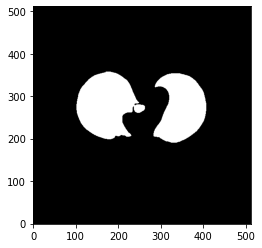

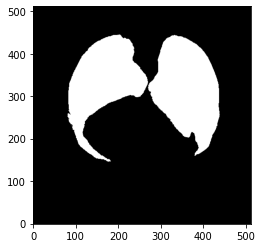

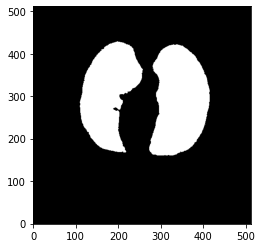

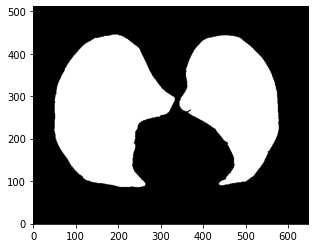

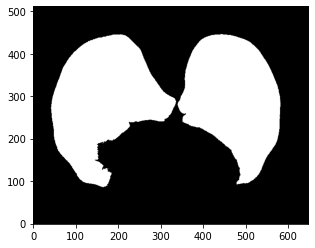

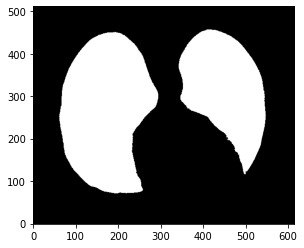

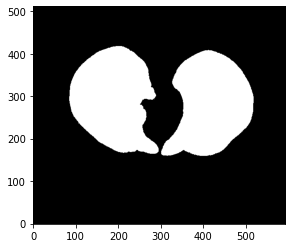

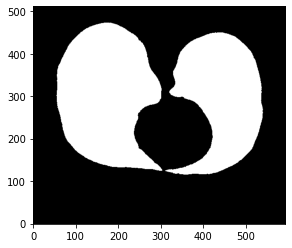

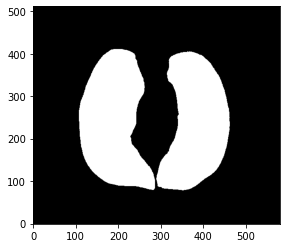

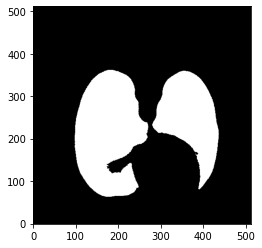

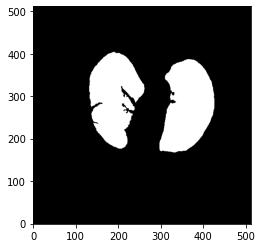

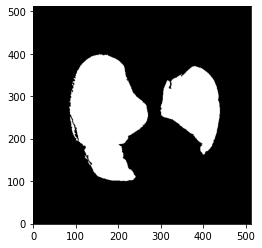

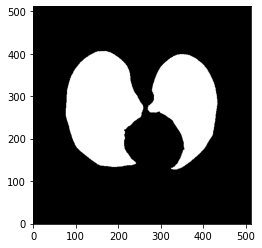

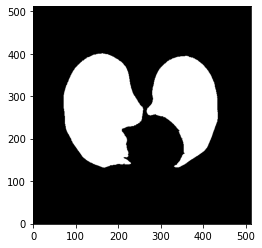

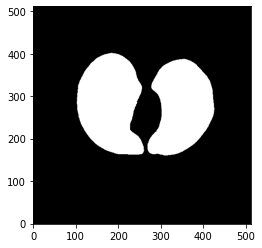

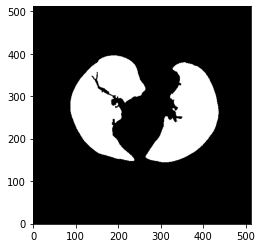

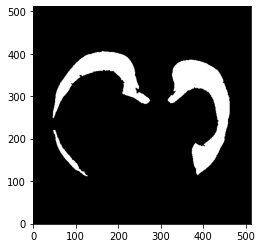

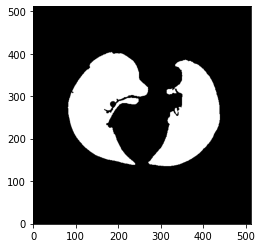

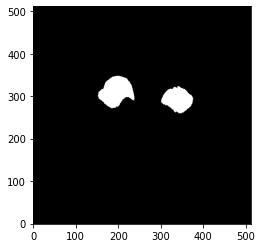

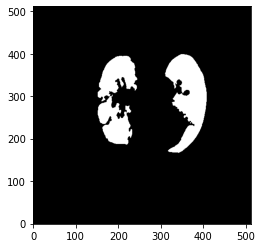

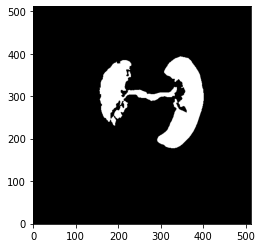

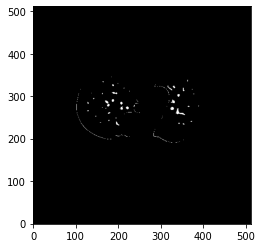

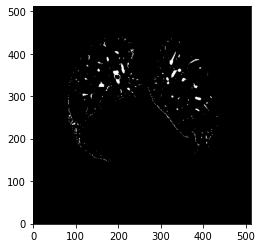

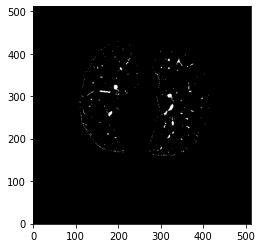

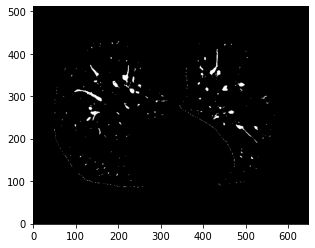

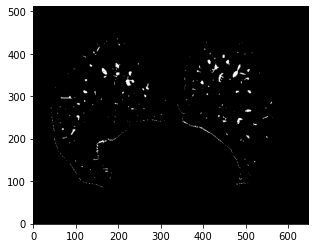

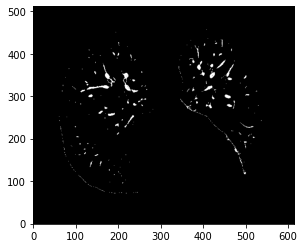

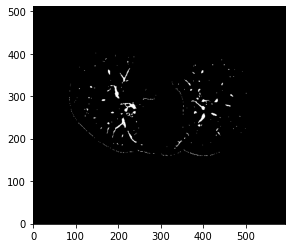

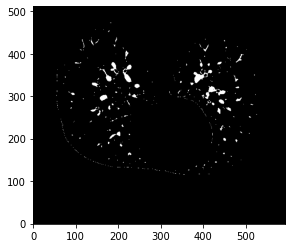

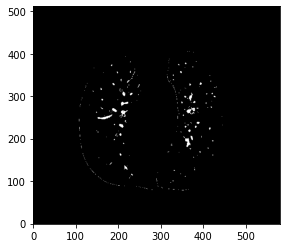

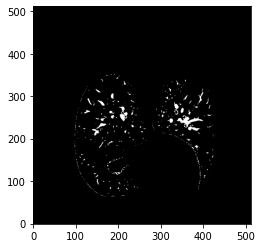

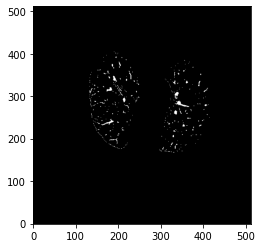

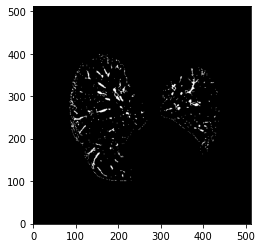

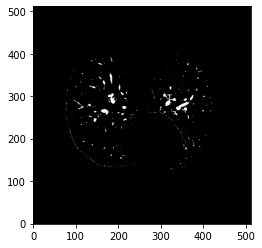

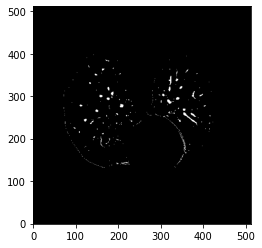

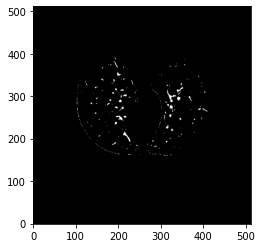

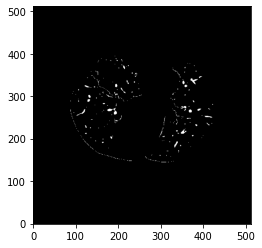

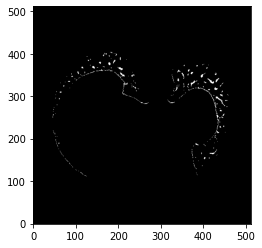

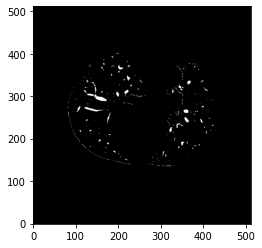

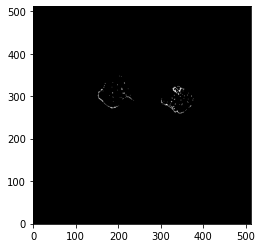

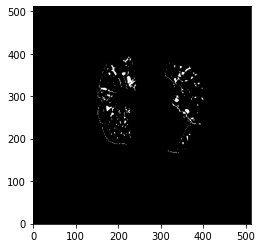

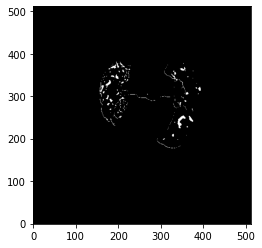

In [1]:
import numpy as np
import nibabel as nib
import os
import shutil
import matplotlib.pyplot as plt
import glob
import csv
from scipy.spatial import ConvexHull
from skimage import measure
from PIL import Image, ImageDraw

def showWindowLevel(ct_numpy, level, window):
    max_value = (level + window) / 2
    min_value = (level - window) / 2
    ct_numpy = ct_numpy.clip(min_value,max_value)
    plt.figure()
    plt.imshow(ct_numpy.T, cmap="gray", origin="lower")
    

for c, exam_path in enumerate(sorted(glob.glob('./Images/slice*.nii.gz'))):

    slice = (nib.load(exam_path)).get_fdata()

    if c == 1:
      plt.figure()
      plt.imshow(slice.T, cmap="gray", origin="lower")
      plt.savefig('First Image')
      showWindowLevel(slice,-200,2000)
      showWindowLevel(slice,-100,1000)
      showWindowLevel(slice,+50,350)
      break    

def makeDirectory(path):
    if os.path.exists(path):
        shutil.rmtree(path)
        os.mkdir(path)
    else:
        os.makedirs(path)

def contourDistance(contour):
    return np.sqrt(np.power(contour[0, 1] - contour[-1, 1], 2) + np.power(contour[0, 0] - contour[-1, 0], 2))


def intensitySegmentation(ct_numpy, min, max):
    clippedImage = ct_numpy.clip(min, max)
    clippedImage[clippedImage != max] = 1
    clippedImage[clippedImage == max] = 0
    return measure.find_contours(clippedImage, 0.95)

def set_is_closed(contour):
    if contourDistance(contour) < 1:
        return True
    else:
        return False

!pip install gdown
!gdown https://drive.google.com/uc?id=1qNpH_0BEy-JJE5VMNfb8kuNN2KfsFLsi
!unzip Images.zip

def findLungs(contours):
    VolumeContours = []
    LungContoursWithBody = []

    for contour in contours:
        hull = ConvexHull(contour)

        if hull.volume > 2000 and contourDistance(contour) < 1:
            LungContoursWithBody.append(contour)
            VolumeContours.append(hull.volume)

    if len(LungContoursWithBody) == 2:
        return LungContoursWithBody
    elif len(LungContoursWithBody) > 2:
        ImagesZip = zip(*sorted(zip(VolumeContours, LungContoursWithBody)));
        VolumeContours, LungContoursWithBody = (list(t) for t in ImagesZip)
        LungContoursWithBody.pop(-1)
        return LungContoursWithBody


def showContour(image, contours, name=None, save=False):
    figure, axis = plt.subplots()
    axis.imshow(image.T, cmap=plt.cm.gray)

    for x in contours:
        axis.plot(x[:, 0], x[:, 1], linewidth=1)

    axis.set_xticks([])
    axis.set_yticks([])

    if save:
        plt.savefig(name)
        plt.close(figure)
    else:
      plt.show()


def createMaskFromPolygon(image, contours):
    lungMask = np.array(Image.new('L', image.shape, 0))

    for contour in contours:
        polygon = list(zip(contour[:, 0], contour[:, 1]))
        NewImg = Image.new('L', image.shape, 0)
        ImageDraw.Draw(NewImg).polygon(polygon, outline=0, fill=1)
        mask = np.array(NewImg)
        lungMask += mask

    lungMask[lungMask > 1] = 1 

    return lungMask.T

def saveNifty(image, name, affine):
    image[image == 1] = 255
    nib.save(nib.Nifti1Image(image, affine), name + '.nii.gz')


def findPixelDimension(CTImage):
    pixelDimension = CTImage.header["pixdim"]
    Dimension = CTImage.header["dim"]

    X = pixelDimension[np.argmax(Dimension)]
    
    Dimension = np.delete(Dimension, np.argmax(Dimension))
    pixelDimension = np.delete(pixelDimension, np.argmax(Dimension))
  
    Y = pixelDimension[np.argmax(Dimension)]

    Dimension = np.delete(Dimension, np.argmax(Dimension))
    pixelDimension = np.delete(pixelDimension, np.argmax(Dimension))
    
    return [X, Y]


def computeArea(mask, pixdim):
    mask[mask >= 1] = 1
    lung_pixels = np.sum(mask)
    return lung_pixels * pixdim[0] * pixdim[1]


myFile = open('lung_volumes.csv', 'w')
lung_areas = []
makeDirectory('./lungImages/')
makeDirectory('./contourImages/')

for c, exam_path in enumerate(sorted(glob.glob('./Images/slice*.nii.gz'))):
    img_name = exam_path.split("/")[-1].split('.nii')[0]
    out_mask_name = './lungImages/' + img_name + "_mask"
    contour_name = './contourImages/' + img_name + "_contour"

    CTImage = nib.load(exam_path)
    pixdim = findPixelDimension(CTImage)
    ct_numpy = CTImage.get_fdata()

    contours = intensitySegmentation(ct_numpy, min=-1000, max=-300)

    lungs = findLungs(contours)
    showContour(ct_numpy, lungs, contour_name,save=True)
    lung_mask = createMaskFromPolygon(ct_numpy, lungs)
    lung_mask[lung_mask == 1] = 255
    ni_img = nib.Nifti1Image(lung_mask, CTImage.affine)
    nib.save(ni_img, out_mask_name + '.nii.gz')
    plt.figure()
    plt.imshow(lung_mask.T, cmap="gray", origin="lower")

    lung_area = computeArea(lung_mask, findPixelDimension(CTImage))
    lung_areas.append([img_name,lung_area])
    print(img_name,'lung area:', lung_area)


with myFile:
    writer = csv.writer(myFile)
    writer.writerows(lung_areas)

myFile = open('vessel_volumes.csv', 'w')
lung_areas_csv = []
ratios = []

makeDirectory('./Vessels/')
makeDirectory('./overlayedVessels/')
makeDirectory('./Figures/')

def euclideanDistance(dx, dy):
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

vessels = './Vessels/'
paths = sorted(glob.glob('./Images/slice*.nii.gz'))
myFile = open('vessel_volumes.csv', 'w')
lung_areas_csv = []
ratios = []

makeDirectory('./Vessels/')
makeDirectory('./Vessel_overlayed/')
makeDirectory('/Figures/')

def create_vessel_mask(lung_mask, ct_numpy, denoise=False):
    vessels = lung_mask * ct_numpy 
    vessels[vessels == 0] = -1000
    vessels[vessels >= -500] = 1
    vessels[vessels < -500] = 0
    plt.figure()
    plt.imshow(vessels.T, cmap="gray", origin="lower")
    if denoise:
      vessels_coords_x, vessels_coords_y = np.nonzero(vessels)  
      for contour in lungs_contour:
          xPoints, yPoints = contour[:, 0], contour[:, 1]
          for (Xcoordinate, Ycoordinate) in zip(vessels_coords_x, vessels_coords_y):
              for (x, y) in zip(xPoints, yPoints):
                  d = euclideanDistance(x - Xcoordinate, y - Ycoordinate)
                  if d <= 0.1:
                      vessels[Xcoordinate, Ycoordinate] = 0
      return vessels
    plt.figure()
    plt.imshow(vessels.T, cmap="gray", origin="lower")
    return vessels


for c, exam_path in enumerate(paths):
    img_name = exam_path.split("/")[-1].split('.nii')[0]
    vessel_name = vessels + img_name + "_vessel_only_mask"
    overlay_name = './Vessel_overlayed/' + img_name + "_vessels"

    ct_img = nib.load(exam_path)
    pixdim = findPixelDimension(ct_img)
    ct_numpy = ct_img.get_fdata()

    contours = intensitySegmentation(ct_numpy, -1000, -300)

    lungs_contour = findLungs(contours)
    lung_mask = createMaskFromPolygon(ct_numpy, lungs_contour)

    lung_area = computeArea(lung_mask, findPixelDimension(ct_img))

    vessels_only = create_vessel_mask(lung_mask, ct_numpy, denoise=True)

    #Overlay of the plot
    plt.figure()
    plt.imshow(ct_numpy.T, 'gray', interpolation='none')
    plt.imshow(vessels_only.T, 'jet', interpolation='none', alpha=0.5)

    plt.title('Overlayed plot')
    plt.savefig(overlay_name)
    plt.close()

    saveNifty(vessels_only, vessel_name, affine=ct_img.affine)

    vessel_area = computeArea(vessels_only, findPixelDimension(ct_img))
    ratio = (vessel_area / lung_area) * 100
    print('Vessel %:', ratio)
    lung_areas_csv.append([img_name, lung_area, vessel_area, ratio])
    ratios.append(ratio)

with myFile:
    writer = csv.writer(myFile)
    writer.writerows(lung_areas_csv)



In [2]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
train_datagen = image.ImageDataGenerator(rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)
test_datagen= image.ImageDataGenerator(    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

train_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/MI_P/Data/train',
    target_size = (224,224),
    batch_size = 8,
    class_mode = 'categorical')
validation_generator = test_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/MI_P/Data/test',
    target_size = (224,224),
    batch_size = 8,
    shuffle=True,
    class_mode = 'categorical')

Below command shows the architecture of the deep learning model with the imagenet weights and ReLU and sigmoid as activation functions.

In [5]:
base_model = tf.keras.applications.EfficientNetB3(weights='imagenet', input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
    layer.trainable=True
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(1024,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(Dropout(0.25))
model.add(Dense(4, activation='sigmoid'))
model.summary()

43941136/43941136 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 gaussian_noise (GaussianNoi  (None, 7, 7, 1536)       0         
 se)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1573888   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                           

the below command is used to train the model based on the images generated in the preceding steps and the epochs may be changed along with the early stopper rate for better accuracy or performance based on the computational resources available.

In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy','AUC','Precision','Recall'])

early_Stopper=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
Epoch_gen = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    steps_per_epoch= 75
    )


Epoch 1/30
75/75 [==============================] - 334s 4s/step - loss: 1.8907 - accuracy: 0.3216 - auc: 0.5636 - precision: 0.2852 - recall: 0.5762 - val_loss: 1.4150 - val_accuracy: 0.3206 - val_auc: 0.5232 - val_precision: 0.2819 - val_recall: 0.2667
Epoch 2/30
75/75 [==============================] - 247s 3s/step - loss: 1.5074 - accuracy: 0.4037 - auc: 0.6586 - precision: 0.3390 - recall: 0.6700 - val_loss: 1.3695 - val_accuracy: 0.3746 - val_auc: 0.5612 - val_precision: 0.3297 - val_recall: 0.3873
Epoch 3/30
75/75 [==============================] - 257s 3s/step - loss: 1.3317 - accuracy: 0.4657 - auc: 0.7091 - precision: 0.3473 - recall: 0.6817 - val_loss: 1.3782 - val_accuracy: 0.3746 - val_auc: 0.5868 - val_precision: 0.3341 - val_recall: 0.4381
Epoch 4/30
75/75 [==============================] - 254s 3s/step - loss: 1.2964 - accuracy: 0.5310 - auc: 0.7264 - precision: 0.3720 - recall: 0.7203 - val_loss: 1.4156 - val_accuracy: 0.3873 - val_auc: 0.5954 - val_precision: 0.3246 -

In [ ]:
model.evaluate(train_generator)
model.evaluate(validation_generator)

Accuracy came out to be higher than 83% for 30 epochs which is impressive.

Below command checks if the image is one of the cancer types and this was done to purely check an input and output of the model prediction.

In [27]:
image_path = 'test3.png'
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(224,224))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
ypred = model.predict(input_arr)
print(ypred)
class1=np.argmax(ypred,-1)
if class1==0:
  op="Adenocarcinoma"
elif class1==1:
  op="Large cell carcinoma"
elif class1==2:
  op="Normal (No Cancer)"
else:
  op="Squamous cell carcinoma"    
print("THE UPLOADED IMAGE IS SUSPECTED AS: "+str(op))  


1/1 [==============================] - 3s 3s/step
[[0.76821446 0.9552573  0.31341255 0.49725106]]
THE UPLOADED IMAGE IS SUSPECTED AS: Large cell carcinoma


In [21]:
model.save('content/model.hdf5')
!pip install streamlit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


User Interface - We have used standard streamlit functions to generate a Web Page User Interface so that the user may upload a CT scan and detect what kind of Lung cancer is present.

Please run the below commands to generate the Webpage and please make sure you have streamlit package installed.

In [24]:
%%writefile WebUI_app.py
import streamlit as st
import tensorflow as tf
import streamlit as st
from tensorflow.keras.preprocessing import image
from PIL import Image, ImageOps
import pandas as pd
import cv2
import numpy as np


html_temp = """ 
  <div style="background-color:blue ;padding:10px">
  <h2 style="color:white;text-align:center;"> LUNG CANCER CLASSIFICATION USING MEDICAL IMAGING TECHNIQUES</h2>
  </div>
  """ 
st.markdown(html_temp, unsafe_allow_html=True) 
html_temp = """ 
  <div style="background-color:teal ;padding:10px">
  <h2 style="color:white;text-align:center;"> Done by Nikhitha Gudi and Venkata Nikhil Kundam</h2>
  </div>
  """ 
st.markdown(html_temp, unsafe_allow_html=True) 
st.header('Types of cancer covered in the dataset are:')
st.subheader('1. Adenocarcinoma')
st.write('Cancer is a medical condition which is due to abnormal, uncontrollable, uncoordinated division of cells.')
st.write('•	Adenocarcinoma may be caused by various reasons. It is usually found in smokers. It may arise in non-smoking subjects as well. It is caused in the outer parts of the lungs and can be found easily. It usually arises in mucus secreting parts of the lungs hence, most found in smokers.')
st.subheader('2. Large cell carcinoma')
st.write('Large-cell carcinoma is a cancer that spreads rapidly and significantly larger in size and must be treated as soon as possible. It is similar to small cell carcinoma.')
st.subheader('3. Squamous cell carcinoma')
st.write('•	Squamous cell carcinoma usually originates from the main airway of the lungs(bronchius) and is caused by squamous flat cells that are present in the inner airway line of the lungs. It is usually caused by excessive smoking and can be treated once discovered.')
st.subheader('4. Normal')
st.write('Normal lung CT scan')
@st.cache(allow_output_mutation=True)
def load_model():
   model=tf.keras.models.load_model('content/model.hdf5')
   return model
with st.spinner('Model is being loaded..'):
    model=load_model()
file = st.file_uploader("Please upload any image from the local machine in case of computer or upload camera image in case of mobile.", type=["jpg", "png","jpeg"])
st.set_option('deprecation.showfileUploaderEncoding', False)
if file is None:
     st.text("Please upload an image file within the allotted file size")
else:
     img = Image.open(file)
     image = tf.keras.preprocessing.image.load_img(file,target_size=(224,224))
     input_arr = tf.keras.preprocessing.image.img_to_array(image)
     input_arr = np.array([input_arr])  # Convert single image to a batch.
     ypred = model.predict(input_arr)
     st.image(img, use_column_width=False)
     a=np.argmax(ypred,-1)
     if a==0:
       st.error('The subject under observation is suspected to have adenocarcinoma.')
     elif a==1:
       st.error('The subject under observation is suspected to have large cell carcinoma.') 
     elif a==2:
       st.success('The subject under consideration is void of any lung/breast cancer.')
     else:
       st.error('The subject under observation is suspected to have squamous cell carcinoma.')   

Overwriting WebUI_app.py


In [26]:
!streamlit run WebUI_app.py & npx localtunnel --port 8501

npx: installed 22 in 2.307s
your url is: https://kind-pillows-post-35-245-59-224.loca.lt



  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.245.59.224:8501

2022-12-11 01:02:21.305837: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
1/1 [==============================] - 2s 2s/step
  Stopping...
^C
